# 숙명여자대학교 Deep Learning 2025 수업 Lab 7: Self-Supervised

# Self-supervised Learning with TensorFlow


## Pretext Task - Rotation

### RotNet
Hypothesis: a model could recognize the correct rotation of an object only if it has the “visual common sense” of what the object should look like self-supervised learning by rotating the entire input images. The model learns to predict which rotation is applied (4-way classification)

### Supervised vs Self-supervised
The accuracy gap between the RotNet based model and the fully supervised Network-In-Network (NIN) model is very small, only 1.64% points
We do not need data labels to train the RotNet based model but achieved similar accuracy with that of the model which used data labels for training

## Import Library and Load MNIST

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

We will use 10000 self-supervision data, 1000 downstream task data, and 300 test data

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
XX_train = X_train[10000:11000]
YY_train = Y_train[10000:11000]
X_train = X_train[:10000]
Y_train = Y_train[:10000]
XX_test = X_test[300:600]
YY_test = Y_test[300:600]
X_test = X_test[:300]
Y_test = Y_test[:300]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
Y_train

array([5, 0, 4, ..., 6, 9, 7], dtype=uint8)

In [ ]:
print('shape of x_train:', X_train.shape)
print('shape of y_train:', Y_train.shape)
print('shape of xx_train:', XX_train.shape)
print('shape of yy_train:', YY_train.shape)
print('shape of x_test:', X_test.shape)
print('shape of y_test:', Y_test.shape)
print('shape of xx_test:', XX_test.shape)
print('shape of yy_test:', YY_test.shape)

shape of x_train: (10000, 28, 28)
shape of y_train: (10000,)
shape of xx_train: (1000, 28, 28)
shape of yy_train: (1000,)
shape of x_test: (300, 28, 28)
shape of y_test: (300,)
shape of xx_test: (300, 28, 28)
shape of yy_test: (300,)


In [ ]:
YY_test

<tf.Tensor: shape=(300, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

## Build RotNet for Pretext Task

### Dataset for Pretext Task (Rotation)
Need to generate rotated images and their labels to train the model for pretext task

[1, 0, 0, 0]: 0 degree rotation

[0, 1, 0, 0]; 90 degree rotation

[0, 0, 1, 0]: 180 degree rotation

[0, 0, 0, 1]; 270 degree rotation

In [ ]:
tf.one_hot([0], depth = 4)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 0., 0., 0.]], dtype=float32)>

In [ ]:
tf.one_hot([3], depth = 4)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 1.]], dtype=float32)>

In [ ]:
n_samples = X_train.shape[0]
X_rotate = np.zeros(shape = (n_samples*4,
                             X_train.shape[1],
                             X_train.shape[2]))
Y_rotate = np.zeros(shape = (n_samples*4, 4))

for i in range(n_samples):
    img = X_train[i]
    X_rotate[4*i-4] = img
    Y_rotate[4*i-4] = tf.one_hot([0], depth = 4)

    # 90 degrees rotation
    X_rotate[4*i-3] = np.rot90(img, k = 1)
    Y_rotate[4*i-3] = tf.one_hot([1], depth = 4)

    # 180 degrees rotation
    X_rotate[4*i-2] = np.rot90(img, k = 2)
    Y_rotate[4*i-2] = tf.one_hot([2], depth = 4)

    # 270 degrees rotation
    X_rotate[4*i-1] = np.rot90(img, k = 3)
    Y_rotate[4*i-1] = tf.one_hot([3], depth = 4)

## Plot Dataset for Pretext Task (Rotation)

<ipython-input-6-5d3354d337ee>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(141)


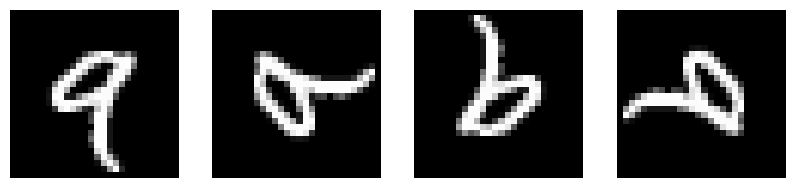

In [ ]:
plt.subplots(figsize = (10, 10))

plt.subplot(141)
plt.imshow(X_rotate[12], cmap = 'gray')
plt.axis('off')

plt.subplot(142)
plt.imshow(X_rotate[13], cmap = 'gray')
plt.axis('off')

plt.subplot(143)
plt.imshow(X_rotate[14], cmap = 'gray')
plt.axis('off')

plt.subplot(144)
plt.imshow(X_rotate[15], cmap = 'gray')
plt.axis('off')

X_rotate = X_rotate.reshape(-1,28,28,1)


## Build Model for Pretext Task (Rotation)



In [ ]:
model_pretext = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3),
                           strides = (2,2),
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (28, 28, 1)),

    tf.keras.layers.MaxPool2D(pool_size = (2, 2),
                              strides = (2, 2)),

    tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = (3,3),
                           strides = (1,1),
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (7, 7, 64)),

    tf.keras.layers.MaxPool2D(pool_size = (2, 2),
                              strides = (2, 2)),

    tf.keras.layers.Conv2D(filters = 16,
                           kernel_size = (3,3),
                           strides = (2,2),
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (3, 3, 32)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units = 4, activation = 'softmax')

])
model_pretext.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 64)               

## Training the model for the pretext task


In [ ]:
model_pretext.compile(optimizer = 'adam',
                      loss = 'categorical_crossentropy',
                      metrics = 'accuracy')

model_pretext.fit(X_rotate,
                  Y_rotate,
                  batch_size = 192,
                  epochs = 50,
                  verbose = 2,
                  shuffle = False)

Epoch 1/50
209/209 - 6s - loss: 0.7540 - accuracy: 0.8119 - 6s/epoch - 27ms/step
Epoch 2/50
209/209 - 1s - loss: 0.1775 - accuracy: 0.9402 - 905ms/epoch - 4ms/step
Epoch 3/50
209/209 - 1s - loss: 0.1236 - accuracy: 0.9565 - 853ms/epoch - 4ms/step
Epoch 4/50
209/209 - 1s - loss: 0.0876 - accuracy: 0.9688 - 935ms/epoch - 4ms/step
Epoch 5/50
209/209 - 1s - loss: 0.0714 - accuracy: 0.9747 - 912ms/epoch - 4ms/step
Epoch 6/50
209/209 - 1s - loss: 0.0599 - accuracy: 0.9792 - 757ms/epoch - 4ms/step
Epoch 7/50
209/209 - 1s - loss: 0.0603 - accuracy: 0.9787 - 875ms/epoch - 4ms/step
Epoch 8/50
209/209 - 1s - loss: 0.0497 - accuracy: 0.9826 - 1s/epoch - 5ms/step
Epoch 9/50
209/209 - 1s - loss: 0.0593 - accuracy: 0.9782 - 674ms/epoch - 3ms/step
Epoch 10/50
209/209 - 1s - loss: 0.0581 - accuracy: 0.9791 - 687ms/epoch - 3ms/step
Epoch 11/50
209/209 - 1s - loss: 0.0395 - accuracy: 0.9857 - 673ms/epoch - 3ms/step
Epoch 12/50
209/209 - 1s - loss: 0.0372 - accuracy: 0.9866 - 665ms/epoch - 3ms/step
Epoch 

#  Build Downstream Task (MNIST Image Classification)
Freezing trained parameters to transfer them for the downstream task


In [ ]:
model_pretext.trainable = False


## Reshape Dataset



In [ ]:
XX_train = XX_train.reshape(-1,28,28,1)
XX_test = XX_test.reshape(-1,28,28,1)
YY_train = tf.one_hot(YY_train, 10, on_value = 1.0, off_value = 0.0)
YY_test = tf.one_hot(YY_test, 10, on_value = 1.0, off_value = 0.0)

## Build Model

### Model: two convolution layers and one fully connected layer

Two convolution layers are transferred from the model for the pretext task

Single fully connected layer is trained only

In [ ]:
model_pretext.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 64)               

In [ ]:
model_pretext.get_layer(index = 0), model_pretext.get_layer(index = 1), \
model_pretext.get_layer(index = 2), model_pretext.get_layer(index = 3)

(<keras.src.layers.convolutional.conv2d.Conv2D at 0x7effaaf03970>,
 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D at 0x7effa0267d60>)

In [ ]:
model_downstream = tf.keras.models.Sequential([
    model_pretext.get_layer(index = 0),
    model_pretext.get_layer(index = 1),
    model_pretext.get_layer(index = 2),
    model_pretext.get_layer(index = 3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
])

model_downstream.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 10)               

Only use (1, 5, 6) digits to visualize latent space in 2-D

In [ ]:
model_downstream.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001,momentum = 0.9),
                         loss = 'categorical_crossentropy',
                         metrics = 'accuracy')

model_downstream.fit(XX_train,
                     YY_train,
                     batch_size = 64,
                     validation_split = 0.2,
                     epochs = 50,
                     verbose = 2,
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 7))

Epoch 1/50
13/13 - 1s - loss: 244.8783 - accuracy: 0.1863 - val_loss: 280.7509 - val_accuracy: 0.2100 - 866ms/epoch - 67ms/step
Epoch 2/50
13/13 - 0s - loss: 189.5958 - accuracy: 0.3900 - val_loss: 156.2193 - val_accuracy: 0.3800 - 62ms/epoch - 5ms/step
Epoch 3/50
13/13 - 0s - loss: 71.0608 - accuracy: 0.6025 - val_loss: 40.6027 - val_accuracy: 0.6650 - 61ms/epoch - 5ms/step
Epoch 4/50
13/13 - 0s - loss: 18.9367 - accuracy: 0.8000 - val_loss: 14.5440 - val_accuracy: 0.8800 - 58ms/epoch - 4ms/step
Epoch 5/50
13/13 - 0s - loss: 9.6877 - accuracy: 0.8675 - val_loss: 14.2533 - val_accuracy: 0.8550 - 69ms/epoch - 5ms/step
Epoch 6/50
13/13 - 0s - loss: 10.2466 - accuracy: 0.8537 - val_loss: 16.0798 - val_accuracy: 0.8400 - 57ms/epoch - 4ms/step
Epoch 7/50
13/13 - 0s - loss: 9.7658 - accuracy: 0.8525 - val_loss: 16.4630 - val_accuracy: 0.8500 - 57ms/epoch - 4ms/step
Epoch 8/50
13/13 - 0s - loss: 9.4948 - accuracy: 0.8537 - val_loss: 14.7292 - val_accuracy: 0.8550 - 58ms/epoch - 4ms/step
Epoch

## Downstream Task Trained Result (Image Classification Result)




1/1 [==============================] - 0s 18ms/step


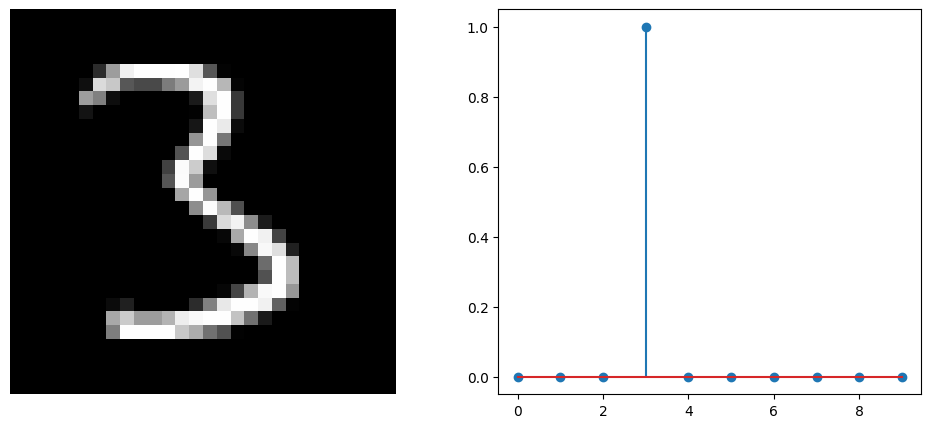

Prediction : 3


In [ ]:
name = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
idx = 9
img = XX_test[idx].reshape(-1,28,28,1)
label = YY_test[idx]
predict = model_downstream.predict(img)
mypred = np.argmax(predict, axis = 1)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.imshow(img.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(predict[0])
plt.show()

print('Prediction : {}'.format(name[mypred[0]]))

In [ ]:
predict

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Supervised Model for Comparison
Convolution Neural Networks for MNIST image classification
Model: Same model architecture with the model for the downstream task
The number of total parameter is the same with the model for the downstream task, but is has zero non-trainable parameters

In [ ]:
model_sup = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3),
                           strides = (2,2),
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (28, 28, 1)),

    tf.keras.layers.MaxPool2D(pool_size = (2, 2),
                              strides = (2, 2)),

    tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = (3,3),
                           strides = (1,1),
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (7, 7, 64)),

    tf.keras.layers.MaxPool2D(pool_size = (2, 2),
                              strides = (2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units = 10, activation = 'softmax')

])
model_sup.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 288)               0         
                                                                 
 dense_3 (Dense)             (None, 10)               

In [ ]:
model_sup.trainable = False
model_rand = tf.keras.models.Sequential([
    model_sup.get_layer(index = 0),
    model_sup.get_layer(index = 1),
    model_sup.get_layer(index = 2),
    model_sup.get_layer(index = 3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
])

model_rand.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 288)               0         
                                                                 
 dense_4 (Dense)             (None, 10)               

In [ ]:
model_sup.trainable = True
model_sup.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001,momentum = 0.9),
                  loss = 'categorical_crossentropy',
                  metrics = 'accuracy')
model_sup.fit(XX_train,
              YY_train,
              batch_size = 32,
              validation_split = 0.2,
              epochs = 50,
              verbose = 2)

Epoch 1/50
25/25 - 1s - loss: 10.5195 - accuracy: 0.1937 - val_loss: 1.7633 - val_accuracy: 0.4050 - 1s/epoch - 42ms/step
Epoch 2/50
25/25 - 0s - loss: 1.5934 - accuracy: 0.4512 - val_loss: 1.1413 - val_accuracy: 0.6600 - 121ms/epoch - 5ms/step
Epoch 3/50
25/25 - 0s - loss: 1.0960 - accuracy: 0.6350 - val_loss: 0.9449 - val_accuracy: 0.7250 - 164ms/epoch - 7ms/step
Epoch 4/50
25/25 - 0s - loss: 0.7750 - accuracy: 0.7387 - val_loss: 0.6583 - val_accuracy: 0.7800 - 143ms/epoch - 6ms/step
Epoch 5/50
25/25 - 0s - loss: 0.5872 - accuracy: 0.7937 - val_loss: 0.6733 - val_accuracy: 0.8200 - 134ms/epoch - 5ms/step
Epoch 6/50
25/25 - 0s - loss: 0.4244 - accuracy: 0.8575 - val_loss: 0.6030 - val_accuracy: 0.8500 - 136ms/epoch - 5ms/step
Epoch 7/50
25/25 - 0s - loss: 0.3536 - accuracy: 0.8788 - val_loss: 0.8806 - val_accuracy: 0.7850 - 140ms/epoch - 6ms/step
Epoch 8/50
25/25 - 0s - loss: 0.2918 - accuracy: 0.9100 - val_loss: 0.6338 - val_accuracy: 0.8350 - 216ms/epoch - 9ms/step
Epoch 9/50
25/25 

In [ ]:
model_rand.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001,momentum = 0.9),
                  loss = 'categorical_crossentropy',
                  metrics = 'accuracy')
model_rand.fit(XX_train,
              YY_train,
              batch_size = 32,
              validation_split = 0.2,
              epochs = 50,
              verbose = 2)

Epoch 1/50
25/25 - 1s - loss: 5.7427e-05 - accuracy: 1.0000 - val_loss: 4.4102 - val_accuracy: 0.8800 - 585ms/epoch - 23ms/step
Epoch 2/50
25/25 - 0s - loss: 4.7053e-06 - accuracy: 1.0000 - val_loss: 4.3888 - val_accuracy: 0.8850 - 85ms/epoch - 3ms/step
Epoch 3/50
25/25 - 0s - loss: 2.2234e-06 - accuracy: 1.0000 - val_loss: 4.3867 - val_accuracy: 0.8850 - 98ms/epoch - 4ms/step
Epoch 4/50
25/25 - 0s - loss: 1.8386e-06 - accuracy: 1.0000 - val_loss: 4.3858 - val_accuracy: 0.8850 - 90ms/epoch - 4ms/step
Epoch 5/50
25/25 - 0s - loss: 1.5934e-06 - accuracy: 1.0000 - val_loss: 4.3850 - val_accuracy: 0.8850 - 90ms/epoch - 4ms/step
Epoch 6/50
25/25 - 0s - loss: 1.4398e-06 - accuracy: 1.0000 - val_loss: 4.3841 - val_accuracy: 0.8850 - 84ms/epoch - 3ms/step
Epoch 7/50
25/25 - 0s - loss: 1.2462e-06 - accuracy: 1.0000 - val_loss: 4.3836 - val_accuracy: 0.8850 - 98ms/epoch - 4ms/step
Epoch 8/50
25/25 - 0s - loss: 1.1299e-06 - accuracy: 1.0000 - val_loss: 4.3832 - val_accuracy: 0.8850 - 82ms/epoch -

## Compare Self-supervised Learning and Supervised Learning

### Pretext Task
Input data: 10,000 MNIST images without labels

### Downstream Task and Supervised Learning (for performance comparison)

Training data: 1,000 MNIST images with labels
Test data: 300 MNIST images with labels

### Key concepts
For transfer learning, we used to train networks like VGG 16 with large image dataset with labels such as ImageNet

With self-supervised learning, we train such networks with unlabeled image datasets which have larger number of data than labeled image datasets have and perform transfer learning

Comparing downstream task performance with that of supervised learning is equal to comparing the performance of (self-supervised) transfer learning and supervised learning performance

In [ ]:
test_self = model_rand.evaluate(XX_test,YY_test,batch_size = 64,verbose = 2)

print("")
print('Self-supervised Learning Accuracy on Test Data:  {:.2f}%'.format(test_self[1]*100))

5/5 - 0s - loss: 4.3968 - accuracy: 0.8400 - 122ms/epoch - 24ms/step

Self-supervised Learning Accuracy on Test Data:  84.00%


In [ ]:
test_self = model_downstream.evaluate(XX_test,YY_test,batch_size = 64,verbose = 2)

print("")
print('Self-supervised Learning Accuracy on Test Data:  {:.2f}%'.format(test_self[1]*100))

5/5 - 0s - loss: 9.4003 - accuracy: 0.8667 - 28ms/epoch - 6ms/step

Self-supervised Learning Accuracy on Test Data:  86.67%


In [ ]:
test_sup = model_sup.evaluate(XX_test,YY_test,batch_size = 64, verbose = 2)

print("")
print('Supervised Learning Accuracy on Test Data:  {:.2f}%'.format(test_sup[1]*100))

5/5 - 0s - loss: 1.2504 - accuracy: 0.8033 - 29ms/epoch - 6ms/step

Supervised Learning Accuracy on Test Data:  80.33%
